In [1]:
from torch import optim
import importlib
import experiment
importlib.reload(experiment)

from experiment import experiment
importlib.reload(experiment)
from experiment.experiment import Experiment
from copy import deepcopy
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

from optimizers import adamw, lion
importlib.reload(adamw)
importlib.reload(lion)
from optimizers.adamw import AdamW
from optimizers.lion import Lion

import matplotlib.pyplot as plt

Using device cpu
Using device cpu


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

data_train = datasets.MNIST(root='/tmp/data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten())
]), train=True)
data_test = datasets.MNIST(root='/tmp/data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten())
]), train=False)

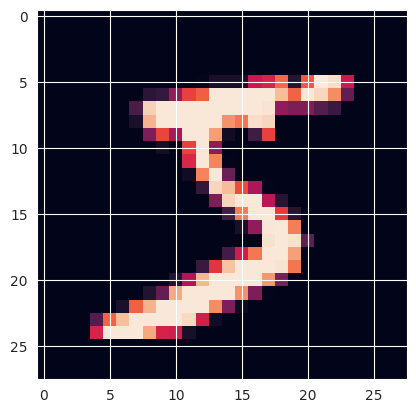

In [3]:
import matplotlib.pyplot as plt
plt.imshow(data_train[0][0].reshape(28, 28))

In [11]:
from torch import nn
simple_model = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.LogSoftmax(dim=1)
)

In [12]:
from torch.utils.data import TensorDataset

X_train = data_train.data.reshape(-1, 28*28).type(torch.FloatTensor) / 255
y_train = data_train.targets

X_test = data_test.data.reshape(-1, 28*28).type(torch.FloatTensor) / 255
y_test = data_test.targets

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
from itertools import product

import os
os.environ["WANDB_SILENT"] = "true"

optimizers = {"Pytorch Adam": optim.Adam, "Lion": Lion, "AdamW": AdamW, "Pytorch AdamW": optim.AdamW}

lrs = [5e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
wds = [0, 1e-4, 1e-3, 1e-2, 2e-2]
EPOCHS = 100

experiments = []

for lr, wd in product(lrs, wds):
    for key, opt in optimizers.items():
        model_clone = deepcopy(simple_model)
        optimizer = opt(model_clone.parameters(), lr=lr, weight_decay=wd)
        experiment = Experiment(model_clone, train_loader, test_loader, optimizer, F.nll_loss,
                                metrics={'accuracy': accuracy_score}, mode="classification", name=key, wandb_config=dict(
                project="mnist-test",
                config={
                    "optimizer": key,
                    "lr": optimizer.defaults["lr"],
                    "dataset": "MNIST",
                    "batch_size": 32,
                    "architecture": "Simple Perceptron",
                    "layers": [28*28, 10, 10],
                    "weight_decay": optimizer.defaults["weight_decay"],
                    "epochs": EPOCHS
                }
            ))
        experiments.append(experiment)
        
print("Number of experiments:", len(experiments))

for experiment in experiments[:1]:
    experiment.run(epochs=100, verbose=1)

Number of experiments: 120
Logging to wandb


--------------------------------------------------
Epoch 1/100 - train_loss: 0.36186946416695914
accuracy_train: 0.8933166666666666
accuracy_test: 0.9252196485623003
--------------------------------------------------
Epoch 2/100 - train_loss: 0.25932587404747803
accuracy_train: 0.9247166666666666
accuracy_test: 0.9203274760383386
--------------------------------------------------
Epoch 3/100 - train_loss: 0.24025897485216458
accuracy_train: 0.9307833333333333
accuracy_test: 0.9260183706070287
--------------------------------------------------
Epoch 4/100 - train_loss: 0.22750089842379093
accuracy_train: 0.9341333333333334
accuracy_test: 0.9345047923322684
--------------------------------------------------
Epoch 5/100 - train_loss: 0.21869982958684364
accuracy_train: 0.9368
accuracy_test: 0.9360023961661342
--------------------------------------------------
Epoch 6/100 - train_loss: 0.21375082263052464
accuracy_train: 0.9377
accuracy_test: 0.9334065495207667
----------------------------

In [9]:
import torch

class TestFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.tensor([2., 1.]))
        
    def forward(self, *args, **kwargs):
        return 7*(self.x[0] - 10)**2 + (self.x[1]+5)**2
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

dummy_data = torch.tensor([[1, 1], [1, 1]])
model = TestFunction()
optimizer = Lion(model.parameters(), lr=0.1, weight_decay=0, betas=(0.9, 0.999))
experiment = Experiment(model, dummy_data, None, optimizer, None, mode="function",  store_path=True)
experiment.run(epochs=100, verbose=0)
len(experiment.get_path())

100

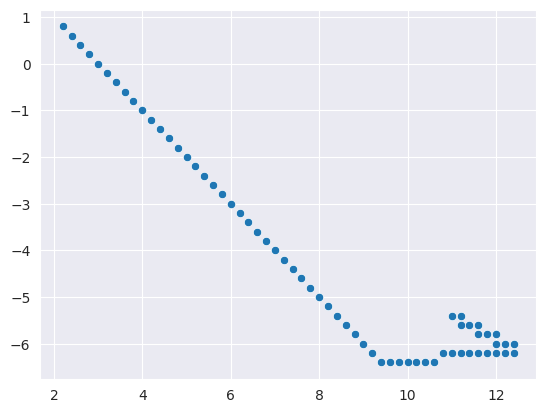

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

x = experiment.get_path()[:, 0, 0]
y = experiment.get_path()[:, 0, 1]
sns.scatterplot(x=x, y=y)

plt.show()